# **딥러닝 모델 훈련 및 추론**

## **1. 드라이브 연결**

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


## **2. 파라미터 설정, 데이터 로드, 데이터셋 분리**

- 데이터 전처리: MinMax Scaler
- 데이터 증강: Sliding Window

In [2]:
# ==========================================
# 1. 라이브러리 임포트 및 설정
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, f1_score
import os
import math

# CPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================================
# 2. 데이터 로드
# ==========================================
# 업로드된 파일명 사용 (환경에 맞게 경로 수정 가능)
file_path = "/content/drive/MyDrive/ASK_2026_FDC/Dataset/MACHINE_Data.xlsx"

if os.path.exists(file_path):
    print(f"Loading data from: {file_path}")
    if file_path.endswith('.xlsx'):
        df = pd.read_excel(file_path)
    else:
        df = pd.read_csv(file_path)
else:
    print("파일을 찾을 수 없습니다. 경로를 확인해주세요.")
    # 임시 빈 데이터프레임 생성 (에러 방지용)
    df = pd.DataFrame()

# 센서 컬럼 정의
sensor_cols = [
    'BCl3 Flow', 'Cl2 Flow', 'RF Btm Pwr', 'RF Btm Rfl Pwr', 'Endpt A',
    'He Press', 'Pressure', 'RF Tuner', 'RF Load', 'RF Phase Err',
    'RF Pwr', 'RF Impedance', 'TCP Tuner', 'TCP Phase Err',
    'TCP Impedance', 'TCP Top Pwr', 'TCP Rfl Pwr', 'TCP Load', 'Vat Valve'
]

# ==========================================
# 3. 데이터 전처리 함수
# ==========================================
"""
    Wafer_ID 별로 그룹화하여 슬라이딩 윈도우를 적용하는 함수

    Args:
        df_target: 대상 데이터프레임
        wafer_col: Wafer ID 컬럼명
        sensor_cols: 센서 데이터 컬럼 리스트
        seq_len: 윈도우 크기
        scaler: 사용할 스케일러 (None이면 새로 생성)
        is_train: 학습 모드 여부 (True면 fit_transform, False면 transform)

    Returns:
        X_all: (N, seq_len, n_features) 형태의 numpy 배열
        scaler: 학습/사용된 스케일러
"""
def create_sequences_per_wafer(df_target, wafer_col, sensor_cols, seq_len, scaler=None, is_train=True):

    # 1. 스케일링 처리
    # (Wafer별로 따로 스케일링하면 Wafer 간의 상대적 크기 정보가 사라질 수 있으므로 전체 기준으로 합니다.)
    data_values = df_target[sensor_cols].values

    if is_train:
        # 학습용: Scaler 생성 및 학습
        if scaler is None:
            scaler = MinMaxScaler()
        data_scaled = scaler.fit_transform(data_values)
    else:
        # 테스트용: 기존 Scaler 사용
        if scaler is None:
            raise ValueError("Test mode requires a fitted scaler.")
        data_scaled = scaler.transform(data_values)

    # 스케일링 된 데이터를 다시 DataFrame에 맵핑 (Wafer ID로 그룹핑하기 위해)
    df_scaled = pd.DataFrame(data_scaled, columns=sensor_cols, index=df_target.index)
    df_scaled[wafer_col] = df_target[wafer_col].values

    all_sequences = []

    # 2. Wafer ID 별로 슬라이딩 윈도우 적용
    unique_wafers = df_scaled[wafer_col].unique()

    for wafer in unique_wafers:
        # 특정 Wafer 데이터 추출
        wafer_data = df_scaled[df_scaled[wafer_col] == wafer][sensor_cols].values

        # 데이터가 윈도우 크기보다 작으면 스킵
        if len(wafer_data) < seq_len:
            continue

        # 슬라이딩 윈도우 생성
        for i in range(len(wafer_data) - seq_len + 1):
            all_sequences.append(wafer_data[i : i + seq_len])

    if len(all_sequences) == 0:
        return np.array([]), scaler

    return np.array(all_sequences), scaler

# ==========================================
# 4. 데이터셋 구성 (실험별 루프)
# ==========================================
experiments = ['l29', 'l31', 'l33']
datasets = {}

print("\n--- Preprocessing Data (Per Wafer Logic) ---")

for exp_id in experiments:
    print(f"\nProcessing Experiment: {exp_id}")

    # 1. 해당 실험 데이터 추출
    exp_df = df[df['Wafer_ID'].str.contains(exp_id, case=False, na=False)]

    if exp_df.empty:
        print(f"No data for {exp_id}")
        continue

    # 2. Wafer ID 추출 및 분할 (Label 기준)
    # 정상 Wafer와 불량 Wafer의 ID 리스트를 확보
    normal_wafer_ids = exp_df[exp_df['Label'] == 'Normal']['Wafer_ID'].unique()
    fault_wafer_ids = exp_df[exp_df['Label'] == 'Fault']['Wafer_ID'].unique()

    print(f"  - Total Normal Wafers: {len(normal_wafer_ids)}")
    print(f"  - Total Fault Wafers: {len(fault_wafer_ids)}")

    # 정상 Wafer가 너무 적으면 스킵
    if len(normal_wafer_ids) < 4:
        print("  - Not enough normal wafers to split.")
        continue

    # 3. Train / Test Split (Wafer ID 기준)
    # 정상 Wafer 중 80%는 학습용, 20%는 테스트용
    n_train_wafers = int(len(normal_wafer_ids) * 0.8)

    train_wafer_ids = normal_wafer_ids[:n_train_wafers]
    test_norm_wafer_ids = normal_wafer_ids[n_train_wafers:]

    # ID를 기준으로 데이터프레임 필터링
    train_df = exp_df[exp_df['Wafer_ID'].isin(train_wafer_ids)]
    test_norm_df = exp_df[exp_df['Wafer_ID'].isin(test_norm_wafer_ids)]
    test_fault_df = exp_df[exp_df['Wafer_ID'].isin(fault_wafer_ids)]

    # 4. 슬라이딩 윈도우 파라미터 설정
    SEQ_LEN = 32

    # (1) Train Data: Fit & Transform
    # 여기서 만들어진 scaler를 반환받아 테스트셋에 적용합니다.
    X_train, scaler = create_sequences_per_wafer(
        train_df, 'Wafer_ID', sensor_cols, SEQ_LEN, scaler=None, is_train=True
    )

    # (2) Test Normal Data: Transform Only
    X_test_normal, _ = create_sequences_per_wafer(
        test_norm_df, 'Wafer_ID', sensor_cols, SEQ_LEN, scaler=scaler, is_train=False     # 학습 데이터로 변환한 Scaler 적용
    )

    # (3) Test Fault Data: Transform Only
    if not test_fault_df.empty:
        X_test_fault, _ = create_sequences_per_wafer(
            test_fault_df, 'Wafer_ID', sensor_cols, SEQ_LEN, scaler=scaler, is_train=False    # 학습 데이터로 변환한 Scaler 적용
        )
    else:
        X_test_fault = np.array([])

    # 5. 결과 저장
    datasets[exp_id] = {
        'X_train': X_train,
        'X_test_norm': X_test_normal,
        'X_test_fault': X_test_fault,
        'scaler': scaler
    }

    print(f"  -> [{exp_id}] Result Shapes:")
    print(f"     X_train     : {X_train.shape}")
    print(f"     X_test_norm : {X_test_normal.shape}")
    print(f"     X_test_fault: {X_test_fault.shape}")

print("\nData preprocessing completed.")

Loading data from: /content/drive/MyDrive/ASK_2026_FDC/Dataset/MACHINE_Data.xlsx

--- Preprocessing Data (Per Wafer Logic) ---

Processing Experiment: l29
  - Total Normal Wafers: 34
  - Total Fault Wafers: 9
  -> [l29] Result Shapes:
     X_train     : (1952, 32, 19)
     X_test_norm : (480, 32, 19)
     X_test_fault: (634, 32, 19)

Processing Experiment: l31
  - Total Normal Wafers: 37
  - Total Fault Wafers: 6
  -> [l31] Result Shapes:
     X_train     : (1973, 32, 19)
     X_test_norm : (546, 32, 19)
     X_test_fault: (356, 32, 19)

Processing Experiment: l33
  - Total Normal Wafers: 37
  - Total Fault Wafers: 6
  -> [l33] Result Shapes:
     X_train     : (1969, 32, 19)
     X_test_norm : (530, 32, 19)
     X_test_fault: (418, 32, 19)

Data preprocessing completed.


## **3. 함수 설정**

In [3]:
# ==========================================
# 1. 데이터 로드 함수 (수정됨)
# ==========================================
def get_data_loaders(exp_id, datasets, batch_size=32):
    print(f"\n📊 [Data Setup] Experiment: {exp_id}")

    # 이미 전처리 단계에서 Wafer_ID 별로 완벽하게 분할된 데이터를 가져옵니다.
    data = datasets[exp_id]
    X_train = data['X_train']
    X_test_norm = data['X_test_norm']
    X_test_fault = data['X_test_fault']

    print(f"   - Train (Normal): {X_train.shape}")
    print(f"   - Test Normal   : {X_test_norm.shape}")
    print(f"   - Test Fault    : {X_test_fault.shape}")

    # 1. Tensor 변환
    train_tensor = torch.FloatTensor(X_train).to(device)
    test_norm_tensor = torch.FloatTensor(X_test_norm).to(device)

    # Fault 데이터가 없는 경우(혹시 모를 예외) 처리
    if len(X_test_fault) > 0:
        test_fault_tensor = torch.FloatTensor(X_test_fault).to(device)
    else:
        test_fault_tensor = torch.FloatTensor([]).to(device)

    # 2. DataLoader 생성 (Train만 셔플)
    train_loader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)

    return train_loader, test_norm_tensor, test_fault_tensor

# ==========================================
# 2. 결과 시각화 함수 (기존 유지)
# ==========================================
def visualize_results(model_name, exp_id, scores, labels, threshold):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    plt.suptitle(f"[{exp_id}] {model_name} Performance Analysis", fontsize=16, fontweight='bold')

    # --- Plot 1: Confusion Matrix ---
    preds = (scores > threshold).astype(int)
    cm = confusion_matrix(labels, preds)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0],
                xticklabels=['Normal', 'Fault'], yticklabels=['Normal', 'Fault'], annot_kws={"size": 14})
    axes[0].set_title("Confusion Matrix", fontsize=14)
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    # --- Plot 2: Anomaly Scores ---
    axes[1].plot(scores, label='Score', color='black', alpha=0.7, linewidth=1)
    axes[1].axhline(y=threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.4f})')

    # 불량 구간 시각화
    fault_indices = np.where(labels == 1)[0]
    if len(fault_indices) > 0:
        start_idx = fault_indices[0]
        end_idx = fault_indices[-1]
        axes[1].axvspan(start_idx, end_idx, color='red', alpha=0.2, label='Actual Fault')

    axes[1].set_title("Anomaly Scores", fontsize=14)
    axes[1].set_xlabel("Sample Index")
    axes[1].set_ylabel("Reconstruction Error")
    axes[1].legend(loc='upper left')

    # --- Plot 3: ROC Curve ---
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    axes[2].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
    axes[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[2].set_xlim([0.0, 1.0])
    axes[2].set_ylim([0.0, 1.05])
    axes[2].set_xlabel('False Positive Rate')
    axes[2].set_ylabel('True Positive Rate')
    axes[2].set_title("ROC Curve", fontsize=14)
    axes[2].legend(loc="lower right")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# ==========================================
# 3. 공통 평가 함수 (기존 유지)
# ==========================================
def evaluate_performance(model_name, exp_id, scores, labels):
    # Best F1 Score를 기준으로 Threshold 자동 계산
    precision, recall, thresholds = precision_recall_curve(labels, scores)

    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * recall * precision / (recall + precision)
    f1_scores = np.nan_to_num(f1_scores) # NaN 처리

    best_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_idx]
    best_thresh = thresholds[best_idx]

    # AUC 계산
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    print(f"\n📌 [{model_name} - {exp_id}] Result Summary")
    print(f"   - AUROC         : {roc_auc:.4f}")
    print(f"   - Best F1-Score : {best_f1:.4f}")
    print(f"   - Best Threshold: {best_thresh:.6f}")

    visualize_results(model_name, exp_id, scores, labels, best_thresh)
    return roc_auc, best_f1


# **모델 구현 및 추론**

## **4. VTimesNet**


🚀 Starting V-TimesNet Experiments Loop...

   Running Experiment: l29

📊 [Data Setup] Experiment: l29
   - Train (Normal): (1952, 32, 19)
   - Test Normal   : (480, 32, 19)
   - Test Fault    : (634, 32, 19)
 -> Input Shape: (Seq_Len=32, Features=19)
 -> Training Model...
Epoch [5/20] Loss: 0.005164
Epoch [10/20] Loss: 0.002045
Epoch [15/20] Loss: 0.001108
Epoch [20/20] Loss: 0.000737


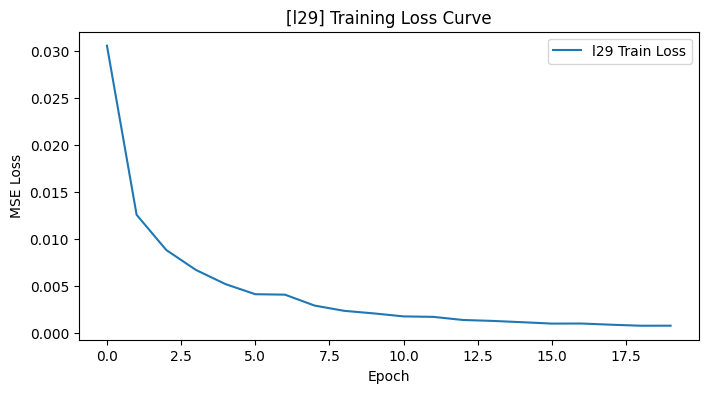

 -> Evaluating...

📌 [V-TimesNet - l29] Result Summary
   - AUROC         : 0.8402
   - Best F1-Score : 0.7959
   - Best Threshold: 0.000738


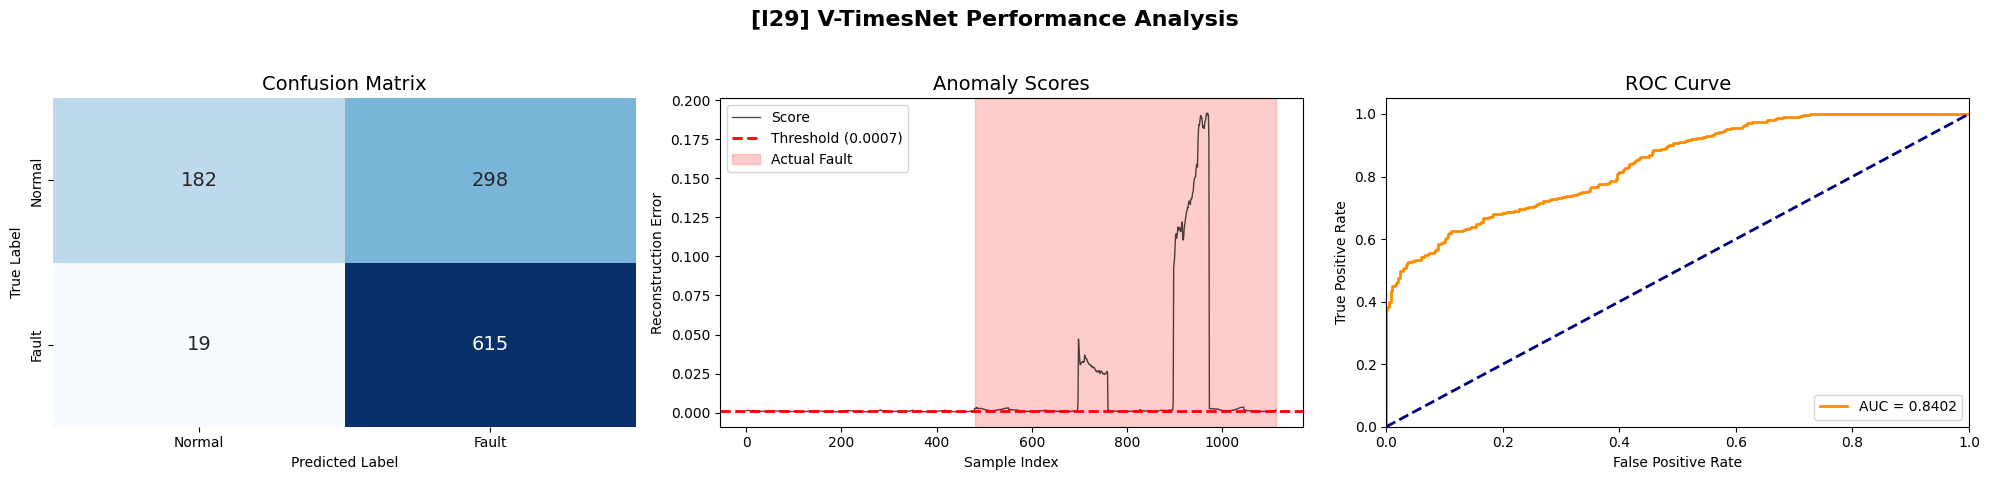


   Running Experiment: l31

📊 [Data Setup] Experiment: l31
   - Train (Normal): (1973, 32, 19)
   - Test Normal   : (546, 32, 19)
   - Test Fault    : (356, 32, 19)
 -> Input Shape: (Seq_Len=32, Features=19)
 -> Training Model...
Epoch [5/20] Loss: 0.004512
Epoch [10/20] Loss: 0.001724
Epoch [15/20] Loss: 0.000843
Epoch [20/20] Loss: 0.000476


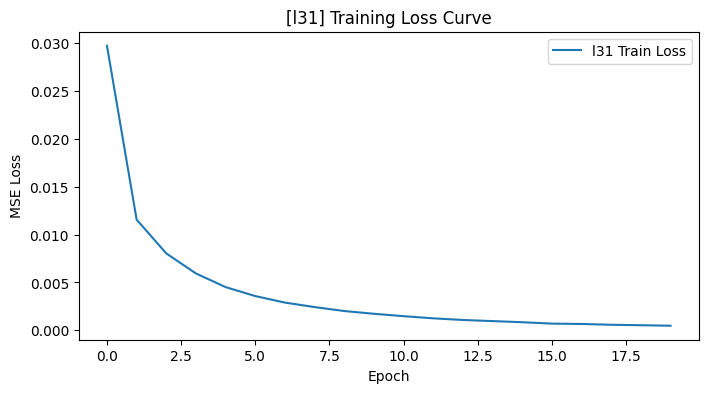

 -> Evaluating...

📌 [V-TimesNet - l31] Result Summary
   - AUROC         : 0.8143
   - Best F1-Score : 0.6848
   - Best Threshold: 0.000684


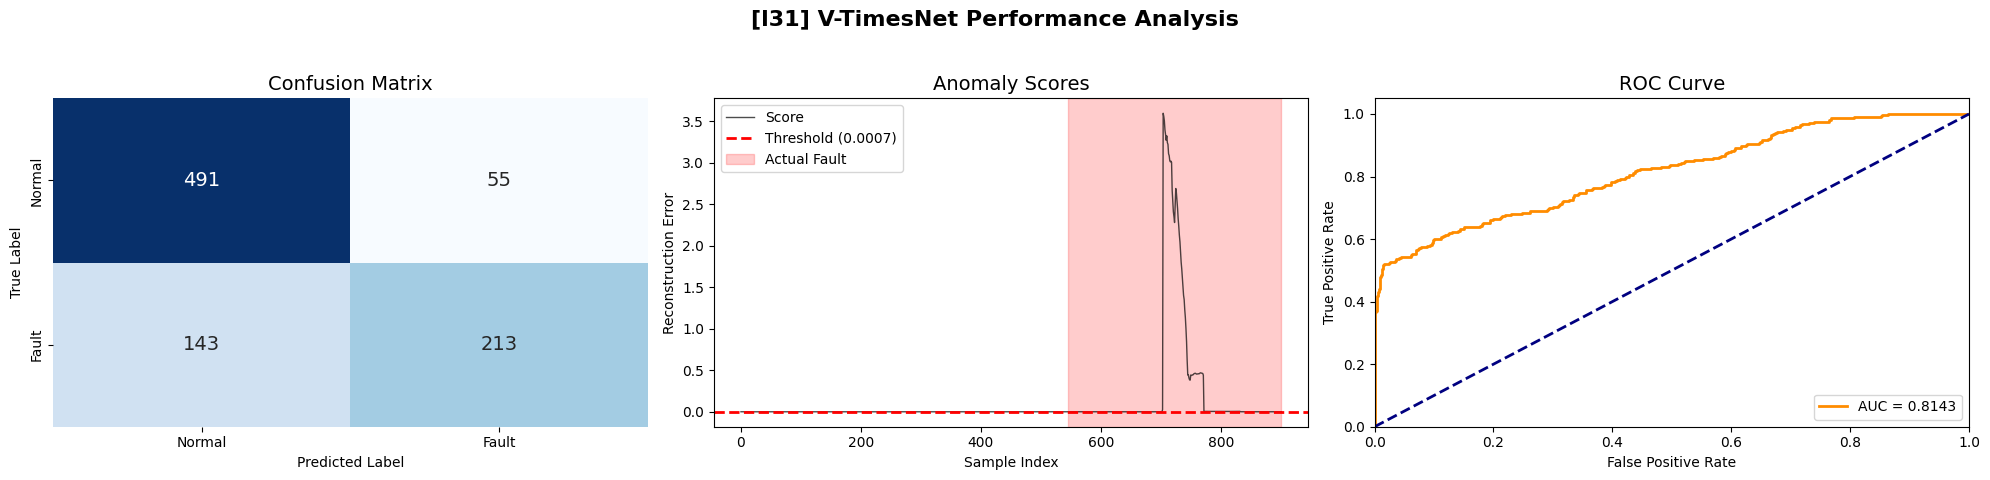


   Running Experiment: l33

📊 [Data Setup] Experiment: l33
   - Train (Normal): (1969, 32, 19)
   - Test Normal   : (530, 32, 19)
   - Test Fault    : (418, 32, 19)
 -> Input Shape: (Seq_Len=32, Features=19)
 -> Training Model...
Epoch [5/20] Loss: 0.004334
Epoch [10/20] Loss: 0.001663
Epoch [15/20] Loss: 0.000968
Epoch [20/20] Loss: 0.000626


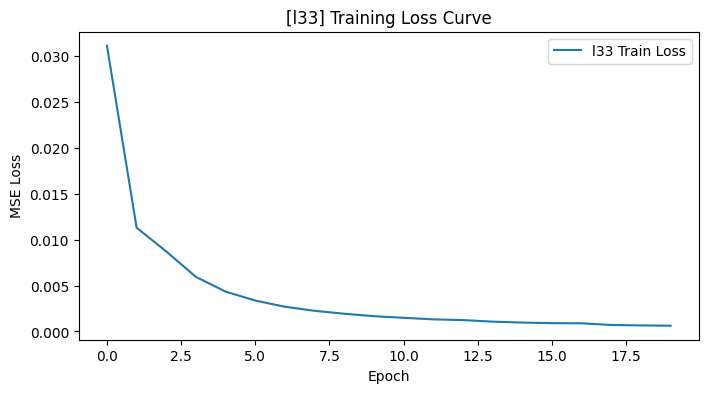

 -> Evaluating...

📌 [V-TimesNet - l33] Result Summary
   - AUROC         : 0.7826
   - Best F1-Score : 0.6833
   - Best Threshold: 0.000656


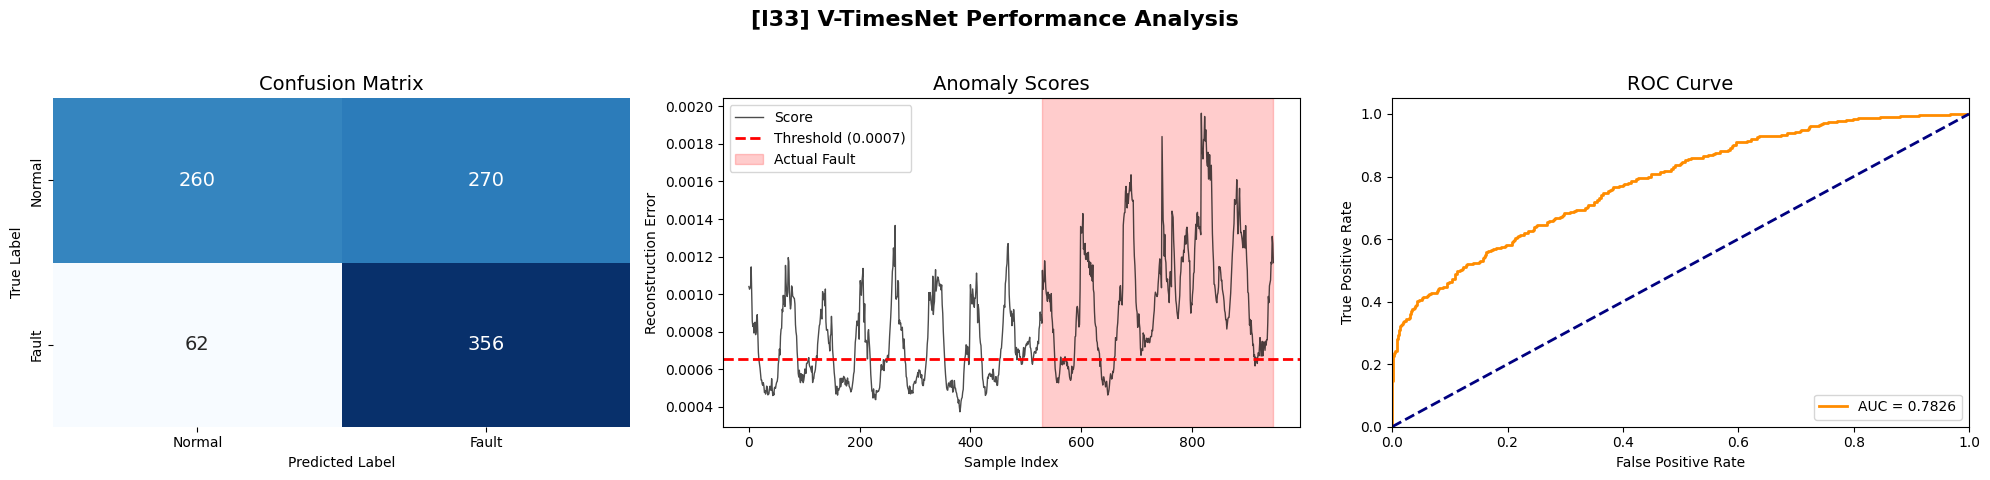


🏆 Final Experiment Summary
Experiment   | AUC        | Best F1   
------------------------------------
l29          | 0.8402     | 0.7959
l31          | 0.8143     | 0.6848
l33          | 0.7826     | 0.6833


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 5. V-TimesNet 모델 정의 (수정 없음)
# ==========================================
class Inception_Block_V1(nn.Module):
    def __init__(self, in_channels, out_channels, num_kernels=6, init_weight=True):
        super(Inception_Block_V1, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_kernels = num_kernels
        kernels = []
        for i in range(self.num_kernels):
            kernels.append(nn.Conv2d(in_channels, out_channels, kernel_size=2 * i + 1,
                                     padding=i, padding_mode='replicate'))
        self.kernels = nn.ModuleList(kernels)
        if init_weight:
            self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        res_list = []
        for i in range(self.num_kernels):
            res_list.append(self.kernels[i](x))
        res = torch.stack(res_list, dim=-1).mean(-1)
        return res

class TimesBlock(nn.Module):
    def __init__(self, seq_len, d_model, top_k=3, d_ff=None, num_kernels=6):
        super(TimesBlock, self).__init__()
        self.seq_len = seq_len
        self.k = top_k
        self.conv = nn.Sequential(
            Inception_Block_V1(d_model, d_ff, num_kernels=num_kernels),
            nn.GELU(),
            Inception_Block_V1(d_ff, d_model, num_kernels=num_kernels)
        )

    def forward(self, x):
        B, T, N = x.size()
        period_list, period_weight = self.fft_period_detection(x, self.k)

        res = []
        for i in range(self.k):
            period = period_list[i]
            if (self.seq_len + period) % period != 0:
                length = (((self.seq_len + period) // period) + 1) * period
            else:
                length = ((self.seq_len + period) // period) * period

            padding = torch.zeros([x.shape[0], (length - (self.seq_len + period)), x.shape[2]]).to(x.device)
            out = torch.cat([x, padding], dim=1)
            out = out.permute(0, 2, 1).reshape(B, N, -1, period).contiguous()
            out = self.conv(out)
            out = out.permute(0, 2, 3, 1).reshape(B, -1, N)
            res.append(out[:, :self.seq_len, :])

        res = torch.stack(res, dim=-1)
        period_weight = F.softmax(period_weight, dim=1)
        period_weight = period_weight.unsqueeze(1).unsqueeze(1).repeat(1, T, N, 1)
        res = torch.sum(res * period_weight, -1)
        res = res + x
        return res

    def fft_period_detection(self, x, k):
        xf = torch.fft.rfft(x, dim=1)
        frequency_list = abs(xf).mean(0).mean(-1)
        frequency_list[0] = 0
        _, top_list = torch.topk(frequency_list, k)
        top_list = top_list.detach().cpu().numpy()
        period = x.shape[1] // top_list
        return period, abs(xf).mean(-1)[:, top_list]

class VTimesNet_AD(nn.Module):
    def __init__(self, seq_len, enc_in, d_model=64, d_ff=64, top_k=3, num_kernels=4, e_layers=1):
        super(VTimesNet_AD, self).__init__()
        self.embedding = nn.Linear(enc_in, d_model)
        self.layer = nn.ModuleList([
            TimesBlock(seq_len, d_model, top_k=top_k, d_ff=d_ff, num_kernels=num_kernels)
            for _ in range(e_layers)
        ])
        self.projection = nn.Linear(d_model, enc_in)

    def forward(self, x):
        enc_out = self.embedding(x)
        for layer in self.layer:
            enc_out = layer(enc_out)
        dec_out = self.projection(enc_out)
        return dec_out

# ==========================================
# 6. 학습 및 평가 함수 (수정 없음)
# ==========================================
def train_model(model, train_loader, epochs=10, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model.train()
    loss_history = []

    for epoch in range(epochs):
        epoch_loss = 0
        for batch_x in train_loader:
            batch_x = batch_x[0].to(device)
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_x)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)
        # 로그가 너무 길어지지 않게 5 Epoch마다 출력
        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.6f}")
    return loss_history

def get_anomaly_scores(model, data_tensor):
    model.eval()
    criterion = nn.MSELoss(reduction='none')
    with torch.no_grad():
        output = model(data_tensor)
        loss = criterion(output, data_tensor)
        score = loss.mean(dim=1).mean(dim=1).cpu().numpy()
    return score

# ==========================================
# 7. 전체 실험 루프 실행 (l29, l31, l33)
# ==========================================
target_experiments = ['l29', 'l31', 'l33']

print("\n🚀 Starting V-TimesNet Experiments Loop...")

results_summary = {}

for exp_id in target_experiments:
    print(f"\n{'='*40}")
    print(f"   Running Experiment: {exp_id}")
    print(f"{'='*40}")

    # 1. 데이터 로드 확인
    if exp_id not in datasets:
        print(f"⚠️ Dataset for {exp_id} not found. Skipping...")
        continue

    # 데이터 로더 생성
    train_loader, test_norm_tensor, test_fault_tensor = get_data_loaders(exp_id, datasets, batch_size=32)

    # 데이터 차원 자동 인식 (SEQ_LEN 변경 대응)
    input_shape = datasets[exp_id]['X_train'].shape
    seq_len = input_shape[1]
    n_features = input_shape[2]

    print(f" -> Input Shape: (Seq_Len={seq_len}, Features={n_features})")

    # 2. 모델 초기화 (실험마다 초기화해야 함)
    model = VTimesNet_AD(
        seq_len=seq_len,
        enc_in=n_features,
        d_model=32,       # 임베딩 차원
        d_ff=64,          # Inception Block 내부 채널
        top_k=3,          # 주요 주기 개수
        e_layers=2        # TimesBlock 층 개수
    ).to(device)

    # 3. 모델 학습
    print(" -> Training Model...")
    history = train_model(model, train_loader, epochs=20, lr=0.001)

    # 학습 곡선 시각화
    plt.figure(figsize=(8, 4))
    plt.plot(history, label=f'{exp_id} Train Loss')
    plt.title(f"[{exp_id}] Training Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.show()

    # 4. 추론 및 점수 계산
    print(" -> Evaluating...")
    test_norm_scores = get_anomaly_scores(model, test_norm_tensor)

    if len(test_fault_tensor) > 0:
        test_fault_scores = get_anomaly_scores(model, test_fault_tensor)

        # 결과 합치기
        test_scores = np.concatenate([test_norm_scores, test_fault_scores])
        test_labels = np.concatenate([np.zeros(len(test_norm_scores)), np.ones(len(test_fault_scores))])

        # 5. 성능 평가 (ROC, F1, Visualization)
        # 이전에 정의한 evaluate_performance 함수 사용
        auc_score, f1_score = evaluate_performance("V-TimesNet", exp_id, test_scores, test_labels)

        results_summary[exp_id] = {'AUC': auc_score, 'F1': f1_score}
    else:
        print(f"⚠️ {exp_id}: No fault data available for evaluation.")

# 최종 요약 출력
print("\n🏆 Final Experiment Summary")
print(f"{'Experiment':<12} | {'AUC':<10} | {'Best F1':<10}")
print("-" * 36)
for exp_id, metrics in results_summary.items():
    print(f"{exp_id:<12} | {metrics['AUC']:.4f}     | {metrics['F1']:.4f}")

## **5. DiffAD**

🚀 Starting Multi-Experiment Execution on cuda
Target Experiments: ['l29', 'l31', 'l33']

🧬 Processing Experiment: l29
   -> Initializing new DiffAD model for l29...
   -> Starting Training (15 Epochs)...


   -> Training Completed for l29.
   -> Running Inference...
      - Normal samples: 480
      - Fault samples : 634

📌 [DiffAD - l29] Result Summary
   - AUROC         : 0.7682
   - Best F1-Score : 0.7476
   - Best Threshold: 0.006106


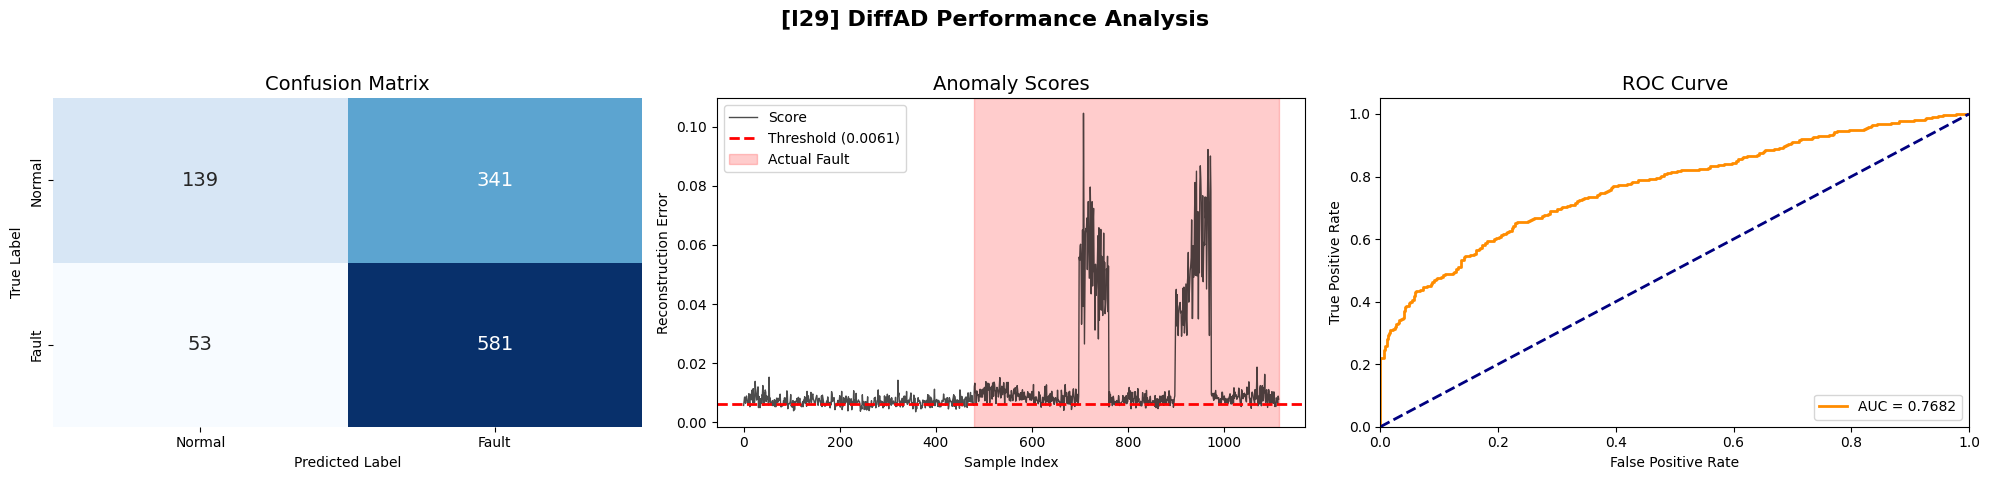

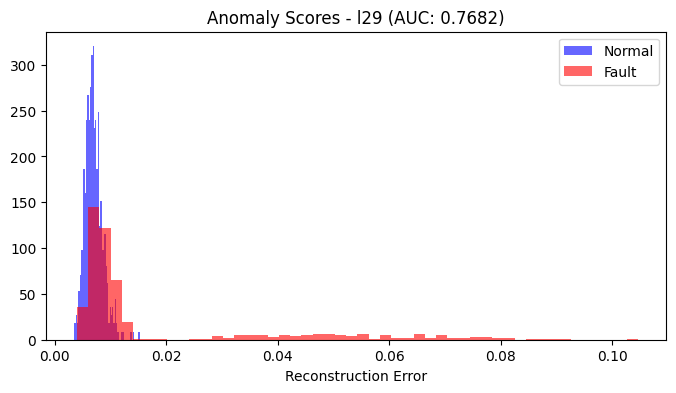


🧬 Processing Experiment: l31
   -> Initializing new DiffAD model for l31...
   -> Starting Training (15 Epochs)...


   -> Training Completed for l31.
   -> Running Inference...
      - Normal samples: 546
      - Fault samples : 356

📌 [DiffAD - l31] Result Summary
   - AUROC         : 0.7415
   - Best F1-Score : 0.6275
   - Best Threshold: 0.007092


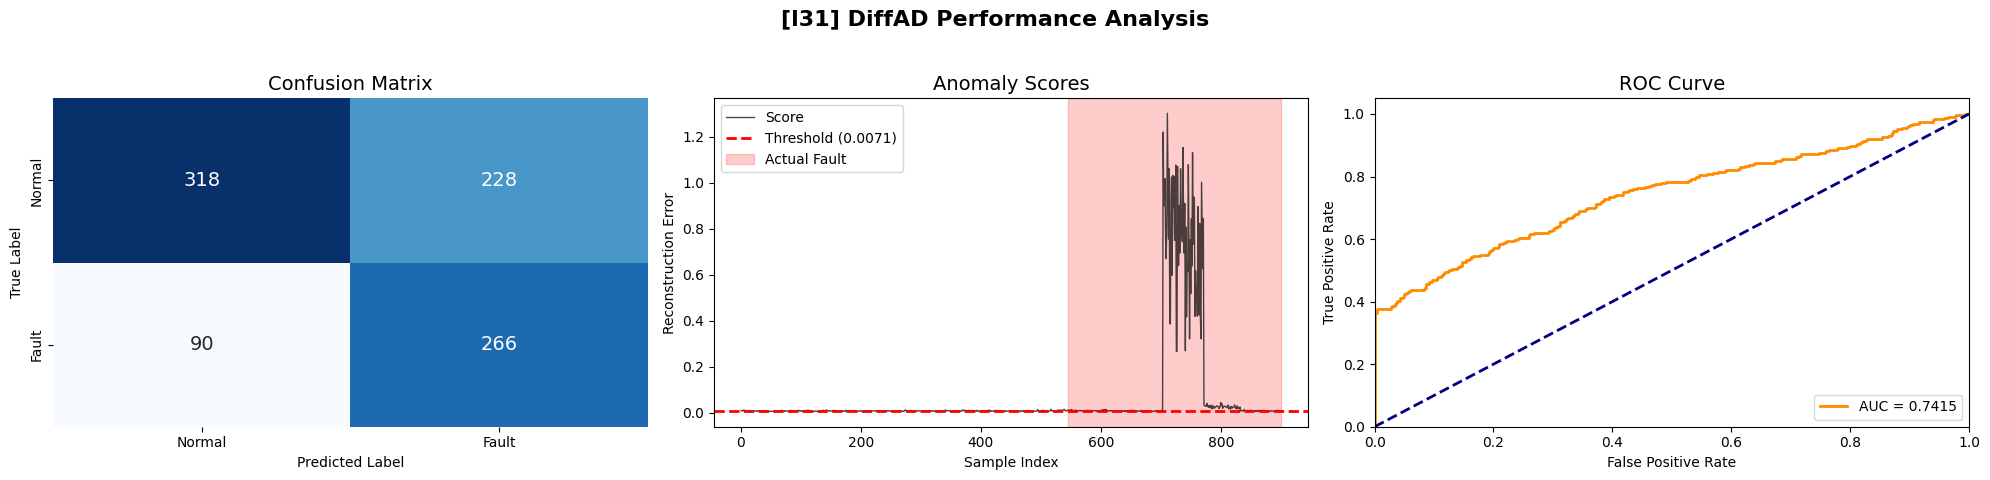

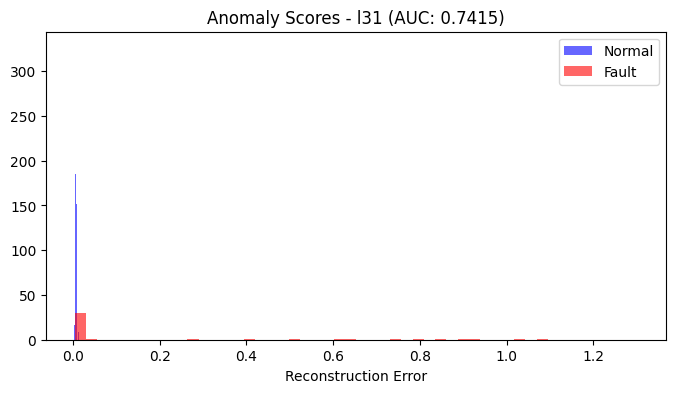


🧬 Processing Experiment: l33
   -> Initializing new DiffAD model for l33...
   -> Starting Training (15 Epochs)...


   -> Training Completed for l33.
   -> Running Inference...
      - Normal samples: 530
      - Fault samples : 418

📌 [DiffAD - l33] Result Summary
   - AUROC         : 0.7585
   - Best F1-Score : 0.6741
   - Best Threshold: 0.005941


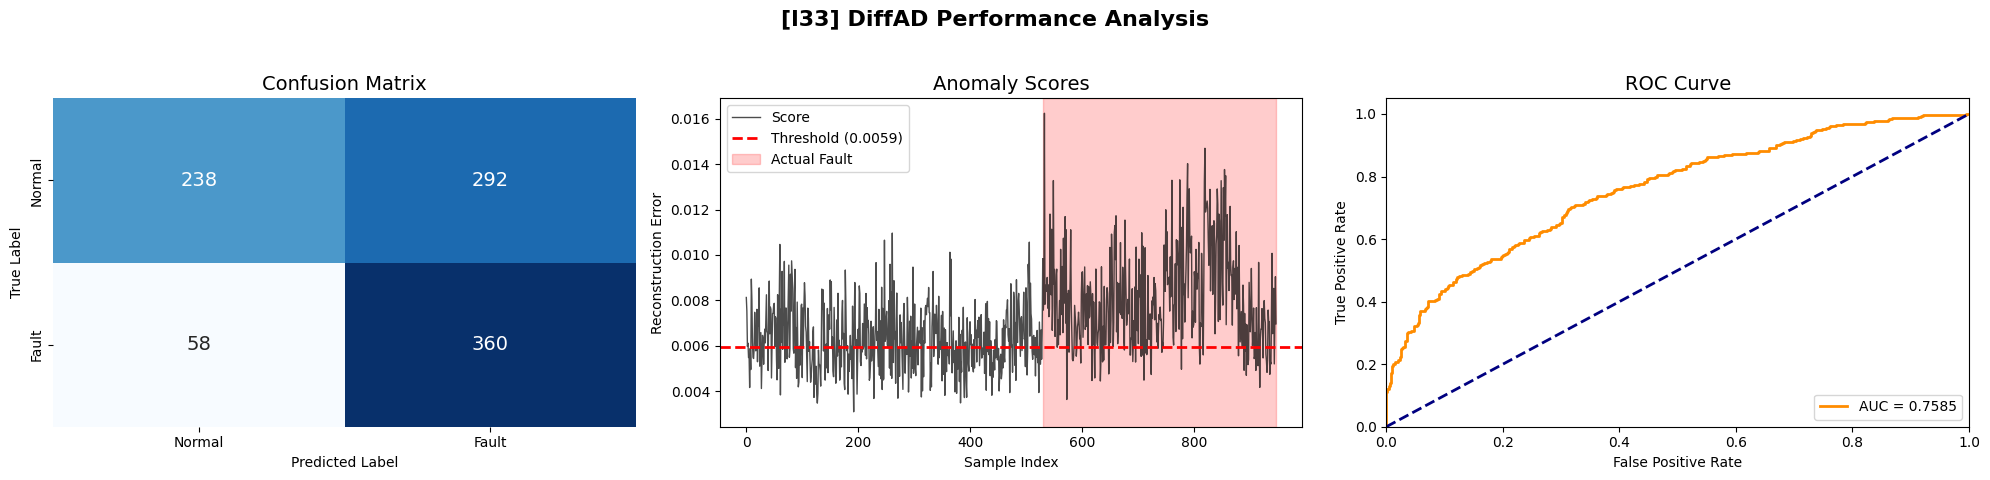

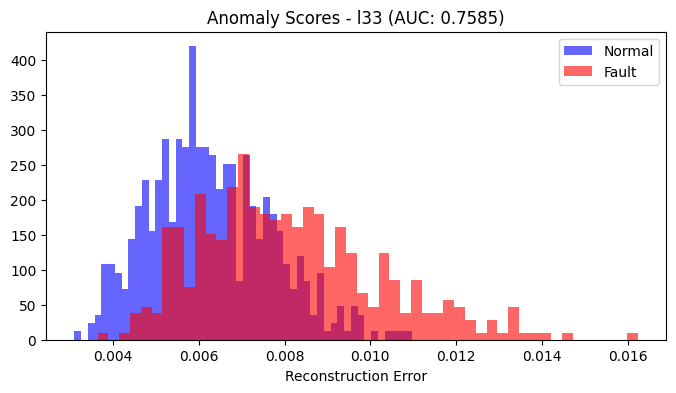


📊 FINAL RESULTS SUMMARY
Experiment   | AUROC      | Best F1   
----------------------------------------
l29          | 0.7682     | 0.7476
l31          | 0.7415     | 0.6275
l33          | 0.7585     | 0.6741


In [6]:
# ==========================================
# 1. 모델 아키텍처 정의 (DiffAD_UNet - Fixed)
# ==========================================
class SinusoidalPosEmbed(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dilation=1):
        super().__init__()
        # Kernel size 3, Padding=Dilation -> Sequence Length 유지
        self.conv1 = nn.Conv1d(in_channels, out_channels, 3, padding=dilation, dilation=dilation)
        self.conv2 = nn.Conv1d(out_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()

        self.shortcut = nn.Identity()
        if in_channels != out_channels:
            self.shortcut = nn.Conv1d(in_channels, out_channels, 1)

    def forward(self, x):
        h = self.relu(self.bn1(self.conv1(x)))
        h = self.bn2(self.conv2(h))
        return self.relu(h + self.shortcut(x))

class DiffAD_UNet(nn.Module):
    def __init__(self, n_features, n_steps=100, dim=64):
        super().__init__()

        # Time Embedding
        self.time_embed = nn.Sequential(
            SinusoidalPosEmbed(dim),
            nn.Linear(dim, dim),
            nn.SiLU(),
            nn.Linear(dim, dim),
        )

        # Encoder
        # 입력 채널: n_features(Noisy) + n_features(Observed Condition) = n_features * 2
        self.inc = nn.Conv1d(n_features * 2, dim, 1)
        self.down1 = ResidualBlock(dim, dim * 2, dilation=1)       # 64 -> 128
        self.down2 = ResidualBlock(dim * 2, dim * 4, dilation=2)   # 128 -> 256

        # Bottleneck
        self.bot1 = ResidualBlock(dim * 4, dim * 4, dilation=4)    # 256 -> 256
        self.bot2 = ResidualBlock(dim * 4, dim * 4, dilation=4)    # 256 -> 256

        # Decoder (채널 수 수정 완료)
        # Skip Connection: h3(256) + h2(128) = 384
        self.up2 = ResidualBlock(dim * 6, dim * 2, dilation=2)     # In: 384 -> Out: 128

        # Skip Connection: h4(128) + h1(64) = 192
        self.up1 = ResidualBlock(dim * 3, dim, dilation=1)         # In: 192 -> Out: 64

        self.outc = nn.Conv1d(dim, n_features, 1)

    def forward(self, x, t, condition_mask=None):
        # x: [Batch, Features, Seq_Len]
        t_emb = self.time_embed(t).unsqueeze(-1)

        # 1. Encoder
        h1 = self.inc(x)
        h1 = h1 + t_emb

        h2 = self.down1(h1)
        h3 = self.down2(h2)

        # 2. Bottleneck
        h3 = self.bot1(h3)
        h3 = self.bot2(h3)

        # 3. Decoder
        h_up2 = torch.cat([h3, h2], dim=1)  # Concatenate
        h4 = self.up2(h_up2)

        h_up1 = torch.cat([h4, h1], dim=1)  # Concatenate
        h5 = self.up1(h_up1)

        out = self.outc(h5)
        return out

# ==========================================
# 2. Diffusion Manager (Weight-Incremental Logic)
# ==========================================
class DiffusionManager:
    def __init__(self, model, device, n_steps=100, beta_start=1e-4, beta_end=0.02):
        self.model = model.to(device)
        self.device = device
        self.n_steps = n_steps

        # Noise Schedule
        self.beta = torch.linspace(beta_start, beta_end, n_steps).to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        # 논문 파라미터 (Eq 10)
        self.lambda_param = 25
        self.N0 = 1.0

    def get_h_weight(self, t_idx):
        """ Calculate h(t) for Weight-Incremental Strategy """
        t_normalized = t_idx / self.n_steps
        return self.N0 * math.exp(-self.lambda_param * t_normalized)

    def q_sample(self, x0, t):
        """ Forward Process: Add Noise """
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None]
        epsilon = torch.randn_like(x0)
        return sqrt_alpha_hat * x0 + sqrt_one_minus_alpha_hat * epsilon, epsilon

    def train_step(self, x0):
        """ Training Step with Random Masking """
        self.model.train()
        batch_size = x0.shape[0]
        t = torch.randint(0, self.n_steps, (batch_size,), device=self.device).long()

        # Random Masking for Self-Supervised Learning
        mask = torch.rand_like(x0) > 0.5
        x_observed = x0 * mask.float()

        # Forward Diffusion
        x_noisy, epsilon = self.q_sample(x0, t)

        # Input: Concat [Noisy Data, Observed Condition]
        model_input = torch.cat([x_noisy, x_observed], dim=1)

        # Predict Noise
        epsilon_pred = self.model(model_input, t)

        # Loss: MSE
        loss = F.mse_loss(epsilon_pred, epsilon)
        return loss

    @torch.no_grad()
    def impute_and_detect(self, x0, mask_ratio=0.2):
        """ Inference Step: Imputation & Error Calculation """
        self.model.eval()
        batch_size = x0.shape[0]

        # Inference Masking (Simulating Missing Values)
        # 논문에서는 Density Ratio 등을 쓰지만 여기서는 Random Masking으로 단순화
        mask = torch.rand_like(x0) > mask_ratio
        x_observed = x0 * mask.float() # Observed values to be kept

        # Start from Gaussian Noise
        x_t = torch.randn_like(x0).to(self.device)

        # Reverse Diffusion
        for t in reversed(range(self.n_steps)):
            t_tensor = torch.full((batch_size,), t, device=self.device, dtype=torch.long)

            # Predict
            model_input = torch.cat([x_t, x_observed], dim=1)
            epsilon_pred = self.model(model_input, t_tensor)

            # Denoising
            alpha = self.alpha[t]
            alpha_hat = self.alpha_hat[t]
            beta = self.beta[t]

            if t > 0:
                noise = torch.randn_like(x0)
            else:
                noise = 0

            x_t = (1 / torch.sqrt(alpha)) * (x_t - ((1 - alpha) / torch.sqrt(1 - alpha_hat)) * epsilon_pred) + torch.sqrt(beta) * noise

            # Conditional Weight-Incremental Step (Eq 11)
            h_t = self.get_h_weight(t)

            # 관측된 부분(Observed)에 대해 생성값과 실제값을 섞음 (점진적 주입)
            x_t_observed = h_t * x_observed + (1 - h_t) * x_t

            # 마스크에 따라 업데이트 (관측된 곳은 섞은 값, 결측된 곳은 생성된 값)
            x_t = mask.float() * x_t_observed + (~mask).float() * x_t

        # Anomaly Score: Reconstruction Error (MSE)
        # 전체 복원 오차를 이상 점수로 사용
        recon_error = torch.sum((x0 - x_t) ** 2, dim=(1, 2)) / (x0.shape[1] * x0.shape[2])

        return recon_error.cpu().numpy(), x_t.cpu().numpy()

# ==========================================
# 3. 데이터 로더 준비 함수
# ==========================================
def prepare_dataloader(data_array, batch_size=64, is_train=True):
    if len(data_array) == 0:
        return None
    # (N, Seq_Len, Features) -> (N, Features, Seq_Len) for Conv1d
    data_tensor = torch.FloatTensor(data_array).permute(0, 2, 1)
    dataset = TensorDataset(data_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=is_train)

# ==========================================
# 2. 전체 실험 루프 (l29, l31, l33)
# ==========================================
experiments = ['l29', 'l31', 'l33']
BATCH_SIZE = 64
LR = 1e-3
EPOCHS = 15       # 실험별 Epoch 설정
N_STEPS = 100     # Diffusion Steps
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results_summary = {} # 결과 저장용

print(f"🚀 Starting Multi-Experiment Execution on {device}")
print(f"Target Experiments: {experiments}")

for exp_id in experiments:
    print(f"\n{'='*60}")
    print(f"🧬 Processing Experiment: {exp_id}")
    print(f"{'='*60}")

    # 1. Check Data Availability
    if exp_id not in datasets:
        print(f"⚠️ Warning: Dataset for {exp_id} not found. Skipping...")
        continue

    # 2. Prepare DataLoaders
    train_loader = prepare_dataloader(datasets[exp_id]['X_train'], BATCH_SIZE, is_train=True)
    test_norm_loader = prepare_dataloader(datasets[exp_id]['X_test_norm'], BATCH_SIZE, is_train=False)
    test_fault_loader = prepare_dataloader(datasets[exp_id]['X_test_fault'], BATCH_SIZE, is_train=False)

    if train_loader is None:
        print(f"⚠️ No training data for {exp_id}. Skipping...")
        continue

    # 3. Initialize NEW Model for this experiment
    print(f"   -> Initializing new DiffAD model for {exp_id}...")
    diff_net = DiffAD_UNet(n_features=19, n_steps=N_STEPS, dim=64)
    diffusion = DiffusionManager(diff_net, device, n_steps=N_STEPS)
    optimizer = torch.optim.Adam(diff_net.parameters(), lr=LR)

    # 4. Training Loop
    print(f"   -> Starting Training ({EPOCHS} Epochs)...")
    diff_net.train()
    for epoch in range(EPOCHS):
        epoch_loss = 0
        # Progress bar for each epoch
        pbar = tqdm(train_loader, desc=f"      Epoch {epoch+1}", leave=False)
        for batch in pbar:
            x_batch = batch[0].to(device)

            optimizer.zero_grad()
            loss = diffusion.train_step(x_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            pbar.set_postfix({'loss': f"{loss.item():.4f}"})

        # Epoch 끝날 때 로그 출력 (선택적)
        # avg_loss = epoch_loss / len(train_loader)
        # print(f"      [Epoch {epoch+1}] Loss: {avg_loss:.6f}")

    print(f"   -> Training Completed for {exp_id}.")

    # 5. Inference & Evaluation
    print(f"   -> Running Inference...")

    def get_scores(loader):
        if loader is None: return np.array([])
        scores = []
        with torch.no_grad():
            for batch in loader:
                x_batch = batch[0].to(device)
                batch_scores, _ = diffusion.impute_and_detect(x_batch, mask_ratio=0.2)
                scores.extend(batch_scores)
        return np.array(scores)

    norm_scores = get_scores(test_norm_loader)
    fault_scores = get_scores(test_fault_loader)

    print(f"      - Normal samples: {len(norm_scores)}")
    print(f"      - Fault samples : {len(fault_scores)}")

    # 6. Performance Evaluation
    if len(norm_scores) > 0 and len(fault_scores) > 0:
        all_scores = np.concatenate([norm_scores, fault_scores])
        all_labels = np.concatenate([np.zeros(len(norm_scores)), np.ones(len(fault_scores))])

        # 사용자 정의 평가 함수 호출
        roc_auc, best_f1 = evaluate_performance("DiffAD", exp_id, all_scores, all_labels)

        results_summary[exp_id] = {'AUC': roc_auc, 'F1': best_f1}

        # 시각화 (각 실험별로 그리기)
        plt.figure(figsize=(8, 4))
        plt.hist(norm_scores, bins=50, alpha=0.6, label='Normal', color='blue', density=True)
        plt.hist(fault_scores, bins=50, alpha=0.6, label='Fault', color='red', density=True)
        plt.title(f"Anomaly Scores - {exp_id} (AUC: {roc_auc:.4f})")
        plt.xlabel("Reconstruction Error")
        plt.legend()
        plt.show()
    else:
        print(f"⚠️ Cannot evaluate {exp_id} due to missing test data.")

    # GPU 메모리 정리 (OOM 방지)
    torch.cuda.empty_cache()

# ==========================================
# 3. 최종 결과 요약
# ==========================================
print("\n" + "="*40)
print("📊 FINAL RESULTS SUMMARY")
print("="*40)
print(f"{'Experiment':<12} | {'AUROC':<10} | {'Best F1':<10}")
print("-" * 40)
for exp, res in results_summary.items():
    print(f"{exp:<12} | {res['AUC']:.4f}     | {res['F1']:.4f}")
print("="*40)